# Exercise session 7: SQP

Before we start the exercise session, let's define some useful functions we will be using later.

In [52]:
import numpy as np
import casadi as cs
from matplotlib import pyplot as plt

In [53]:
def plot_iterates(x: np.array):
    plt.figure()
    plt.plot(x[0,:], x[1,:],color='r')
    plt.plot(x[0,:], x[1,:],color='r', marker="o")
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

def plot_convergence(n_iter, gradients_lagrangian):
    plt.figure()
    plt.semilogy(np.arange(n_iter), gradients_lagrangian.squeeze(), marker='.')
    plt.grid()
    plt.title('Gradient norm iterations')
    plt.xlabel('iterations')
    plt.ylabel('$\\Vert \\nabla L(x_k, \\lambda_k)\\Vert_\\infty$')
    plt.show()

In [54]:
def finite_difference_jacobian(fun, x0: np.array):
    # make sure x0 is a column vector
    Nx,cols = x0.shape
    if cols != 1:
        raise ValueError('x0 needs to be a column vector')

    # make sure fun returns a column vector
    f0 = fun(x0)
    Nf,cols = f0.shape
    if cols != 1:
        raise ValueError('fun needs to return a column vector');

    # initialize empty J
    J = np.zeros((Nf, Nx))

    # perform the finite difference jacobian evaluation
    h = 1e-6
    for k in range(Nx):
        x = x0.copy()
        x[k] = x[k] + h
        f = fun(x)
        grad = (f - f0)/h
        J[:,[k]] = grad

    return f0, J


In [55]:
def line_search(fun, x0, Jdk, dk, sigma, beta):
    # Line search using Armijo conditions and backtracking
    # fun   - scalar function
    # x0    - initial guess
    # Jdk   - J is gradient of fun at x0, Jdk is J'*dk
    # dk    - search direction
    # sigma - Armijo condition scaling function
    # beta  - backtracking parameter

    # make sure sigma and beta are in reasonable range
    if sigma <= 0 or 1 <= sigma:
        raise ValueError('sigma must be in (0,1)')

    if beta <= 0 or 1 <= beta:
        raise ValueError('beta must be in (0,1)')
    
    too_many_steps_counter = 1000

    # initialize alpha, evaluate function
    alpha = 1
    f0 = fun(x0)

    trial_x = x0 + alpha*dk
    while fun(trial_x) > f0 + sigma*alpha*Jdk:
        # trial step in x
        alpha   = beta * alpha
        trial_x = x0 + alpha*dk

        # if the line search takes too many iterations, throw an error
        too_many_steps_counter = too_many_steps_counter - 1
        if too_many_steps_counter == 0:
            raise RuntimeError('line search fail - took too many iterations')

    return trial_x, alpha


In [56]:
def merit_function_equality_constrained_sqp(ffun, hfun, c, x):
    f = ffun(x)
    h = hfun(x)    
    ret = f + c*np.linalg.norm(h, 1) #Calculates the 1-norm
    return ret

def merit_function_inequality_constrained_sqp(ffun, hfun, gfun, c, x):

    f = ffun(x)    
    h = hfun(x)
    g = gfun(x)
    
    ret = f + c* (np.linalg.norm(h, 1) + np.linalg.norm(np.fmax(g,0),1))

    return ret

$\renewcommand\R{\mathrm{I\!R}}$
## Exercise 1
Consider the problem:
\begin{align*}
\begin{split}
\min_{x\in\R^n} & \quad f(x) \\
\text{s.t.} & \quad h(x) = 0
\end{split}
\end{align*}
with $f\colon\R^n\to\R$, $h\colon\R^n\to\R^m$.

**Newton Lagrange Method**: We use Lagrange multipliers $\lambda\in\R^m$ to handle the equality constraints:
\begin{align*}
{L}(x,\lambda) = f(x) + \lambda^Th(x).
\end{align*}
The optimality conditions are given by:
\begin{align*}
 0 = \nabla_x{L}(x,\lambda) &= \nabla_x f(x) + \nabla_x h(x) \lambda\\
 0 = \nabla_\lambda {L}(x,\lambda) &= h(x).
\end{align*}
Applying Newton's method on the KKT system yields for a given $x_k$ and $\lambda_k$:
\begin{align}
  \begin{pmatrix}
    \nabla_{xx}^2{L}_k & \nabla h_k \\
    \nabla h_k^T & 0 \\
  \end{pmatrix}
  \begin{pmatrix}
    \Delta x \\
    \lambda
  \end{pmatrix}
  =
  \begin{pmatrix}
    -\nabla f_k \\
    -h_k
  \end{pmatrix}.
\end{align}
By solving this linear system, we obtained $\Delta x$ and $\lambda$. The next iterate is calculated by
\begin{align*}
    &x_{k+1} = x_k + \Delta x,\\
    &\lambda_{k+1} = \lambda.
\end{align*}

**QP Interpretation**: Consider the quadratic program:
\begin{align}
\begin{split}
\min_{\Delta x} & \ \Delta x^T\nabla f_k + \frac{1}{2}\Delta x^T \nabla_{xx}^2{L}_k \Delta x \\
\text{s.t.} & \ \nabla h_k^T \Delta x + h_k = 0
\end{split}
\end{align}
Introduce Lagrange multipliers $\lambda$:
\begin{align*}
{L}(\Delta x,\lambda) = \Delta x^T\nabla f_k + \frac{1}{2}\Delta x^T \nabla_{xx}^2{L}_k\Delta x  + \lambda^T(\nabla h_k^T \Delta x + h_k )
\end{align*}
and the optimality conditions are:
\begin{align*}
\nabla f_k + \nabla_{xx}^2 {L}_k \Delta x + \nabla h_k \lambda &= 0\\
\nabla h_k^T\Delta x + h_k &= 0.
\end{align*}
Rewriting this as a linear system, we have:
\begin{align}
  \begin{pmatrix}
    \nabla_{xx}^2{L}_k & \nabla h_k \\
    \nabla h_k^T & 0 \\
  \end{pmatrix}
  \begin{pmatrix}
    \Delta x \\
    \lambda
  \end{pmatrix}
  =
  \begin{pmatrix}
    -\nabla f_k \\
    -h_k
  \end{pmatrix}.
\end{align}

**Since this KKT system is identical to the one we obtained before, we can use a QP solver directly solve instead of solving this linear system ourselves.**

### Exercise 1.a
Complete the code below to use the QP solver OSQP interfaced through the package Casadi, instead of solving for the linear system of equations. A description of the Casadi conic function can be found in https://web.casadi.org/docs/#quadratic-programming.
You will need to get $\lambda$ from the output of conic.
As before, use BFGS to approximate the Hessian $\nabla_{xx}^2 {L}$.

In [57]:
def minimize_eq_sqp(ffun, hfun, x0: np.array, with_line_search=True, with_powells_trick=False):

    # convergence tolerance
    grad_tol = 1e-4
    max_iters = 100
    
    # make sure x0 is a column vector
    n_variables, cols = x0.shape
    if cols != 1:
        raise ValueError('x0 needs to be a column vector')
    
    # make sure ffun returns a scalar
    f0 = ffun(x0)
    if len(f0) != 1:
        raise ValueError('ffun must return a scalar')
    
    # make sure hfun returns a column vector
    h0 = hfun(x0)
    n_eq_constraints, cols = h0.shape
    if cols != 1:
        raise ValueError('hfun needs to return a column vector')
    
    # a log of the iterations
    x_iters = np.zeros((n_variables, max_iters))
    gradient_lagrangian_iters = np.zeros((1,max_iters))
    
    # initial variables
    x = x0.copy()
    lambdA = np.zeros((n_eq_constraints, 1)) # lambda is a key word
    
    # initialize B
    B = np.eye(n_variables)
    
    # evaluate the initial f and it's jacobian J
    _, J = finite_difference_jacobian(ffun, x)
    
    # evaluate the initial h and it's jacobian J_h
    h, J_h = finite_difference_jacobian(hfun, x)

    # Define the QP solver with Casadi
    B_placeholder = cs.DM.ones(n_variables, n_variables)
    Jh_placeholder = cs.DM.ones(n_eq_constraints, n_variables)
    qp_struct = {   'h': B_placeholder.sparsity(),
                    'a': Jh_placeholder.sparsity()}
            
    qp_solver_opts = {}
    qp_solver_opts["print_out"] = False
    qp_solver_opts["osqp"] = {"verbose": False,
                              "eps_abs":1e-4,
                              "eps_rel":1e-4,
                              "eps_prim_inf":1e-5,
                              "eps_dual_inf":1e-5,
                              "max_iter":4000}
    
    qp_solver = cs.conic("qpsol", "osqp", qp_struct, qp_solver_opts)

    # Main optimization loop
    for k in range(max_iters):
        
        # check for divergence
        x_norm_inf = np.linalg.norm(x, np.inf)
        if x_norm_inf > 1e6:
            raise ValueError('minimize_sqp has diverged, ||x||_\{inf\}: %.3g',x_norm_inf)
        
        # store x in the iteration log
        gradient_lagrangian = J.T + J_h.T  @ lambdA
        norm_gradient_lagrangian = np.linalg.norm(gradient_lagrangian, np.inf)
        norm_infeasbility = np.linalg.norm(h, np.inf)

        norm_convergence = np.fmax(norm_gradient_lagrangian, norm_infeasbility)

        x_iters[:,[k]] = x.copy()
        gradient_lagrangian_iters[0, k] = norm_convergence
        
        print('iteration: {},   convergence_metric: {:.2e}'.format(k, norm_convergence))
    
        # check for convergence
        if norm_convergence < grad_tol:
            x_iters = x_iters[:,:k+1]
            gradient_lagrangian_iters = gradient_lagrangian_iters[:,:k+1]
            print('acceptable solution found\n')
            return x, x_iters, gradient_lagrangian_iters
        
        # lambdA_old = lambdA.copy()
        x_old = x.copy()
        
        # find the search direction and lambda

        ### OLD SCHOOL WITH SOLVING LINEAR SYSTEM -----------------------------
        # M = np.vstack((np.hstack((B, J_h.T)), 
        #                np.hstack((J_h,  np.zeros((n_eq_constraints, n_eq_constraints))))
        #                ))
        # L0 = np.vstack((-J.T, -h))
        # sol = np.linalg.solve(M, L0)
        # dk = sol[:n_variables]
        # lambdA = sol[n_variables:]

        ### NEW APPROACH SOLVING QP
        # raise NotImplementedError("TODO: Implement the QP solver")
        lba = [-h]
        uba = lba
        result = qp_solver(h=B,
                           a=J_h,
                           g=J,
                           lba=lba,
                           uba=uba)
        dk = np.array(result['x'])
        lambdA = np.array(result['lam_a'])
        
        ### END OF DIFFERENT APPROACHES ---------------------------------------
        # take the line search
        if with_line_search:
            sigma = 0.01
            beta  = 0.6
            c     = 100
            # calculate the directional derivative
            directional_derivative = J @ dk - c*np.linalg.norm(h,1)
            merit_fun = lambda y : merit_function_equality_constrained_sqp(ffun, hfun, c, y)
            x, _ = line_search(merit_fun, x, directional_derivative, dk, sigma, beta)
        else:
            x += dk

        # ------ BFGS Hessian Approximation ------
        J_old = J.copy()
        J_h_old = J_h.copy()
        
        # evaluate F and it's jacobian J
        _, J = finite_difference_jacobian(ffun, x)
    
        # evaluate h and it's jacobian J_h
        h, J_h = finite_difference_jacobian(hfun, x)
        
        Lx_old = J_old.T + J_h_old.T @ lambdA
        Lx     = J.T     + J_h.T @ lambdA
        
        s = x - x_old
        y = Lx - Lx_old

        # Powell's trick
        if with_powells_trick:
            if y.T @ s >= 0.2 * s.T @ B @ s:
                theta = 1
            else:
                theta = (0.8 * s.T @ B @ s)/(s.T @ B @ s -s.T @ y)

            y = theta*y + (1-theta) * B @ s
        else:
            y = y

        B = B - B @ (s@s.T) @ B/(s.T@B@s) + y@y.T/(s.T @ y)

        # Symmetrize Hessian (only needed for numerical accuracy)
        B = (B + B.T) / 2. # Symmetrize Hessian, only needed due to numerical inaccuracy, so that quadprog doesn't complain
        
        ###############################################################    
   

    raise RuntimeError('minimize_eq_sqp: max iterations exceeded')


### Exercise 1.b
Verify your modification by using your solver on the problem from last time:
\begin{align*}
\begin{split}
\min_{x,y} & \ \frac{1}{2}\left( x^2 + \left(\frac{y}{2}\right)^2 \right) \\
\text{s.t.} & \ y = (x-1)^2 - x + 3
\end{split}
\end{align*}

In [58]:
# Objective function
def ffun(xy: np.array):
    x = xy[0]
    y = xy[1]    
    f = 0.5*(y/2)**2 + 0.5*x**2
    return np.array([f])

# Equality constraint function
def hfun(xy: np.array):
    x = xy[0]
    y = xy[1]    
    h = y - (3 + (x-1)**2 - x)
    return np.array([h])

iteration: 0,   convergence_metric: 3.00e+00
iteration: 1,   convergence_metric: 1.63e+00
iteration: 2,   convergence_metric: 3.57e+02
iteration: 3,   convergence_metric: 8.98e+01
iteration: 4,   convergence_metric: 2.34e+01
iteration: 5,   convergence_metric: 7.12e+00
iteration: 6,   convergence_metric: 4.23e+00
iteration: 7,   convergence_metric: 4.84e+01
iteration: 8,   convergence_metric: 1.31e+01
iteration: 9,   convergence_metric: 4.69e+00
iteration: 10,   convergence_metric: 6.99e+00
iteration: 11,   convergence_metric: 3.41e+00
iteration: 12,   convergence_metric: 2.35e+01
iteration: 13,   convergence_metric: 5.98e+00
iteration: 14,   convergence_metric: 1.41e+00
iteration: 15,   convergence_metric: 2.93e-01
iteration: 16,   convergence_metric: 5.37e-02
iteration: 17,   convergence_metric: 5.01e-04
iteration: 18,   convergence_metric: 5.14e-06
acceptable solution found



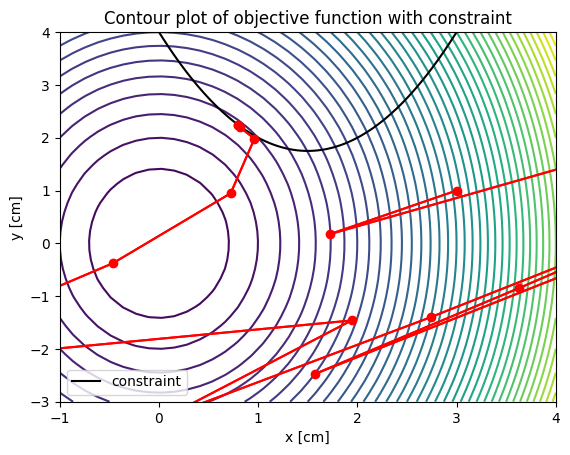

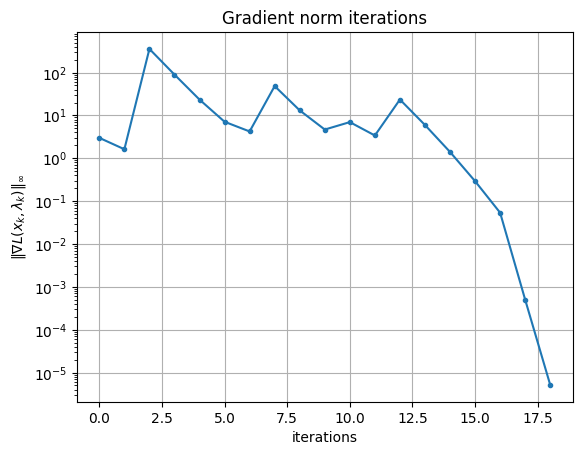

In [59]:
def ex7_eq_sqp(with_line_search=True, with_powells_trick=False, plot_function=False):

    # ------ First let's plot the function ------
    # Define the the meshgrids for the 2D function
    xlist = np.linspace(-1, 4, 40)
    ylist = np.linspace(-3, 4, 40)
    [X,Y] = np.meshgrid(xlist, ylist)
    obj = np.vectorize(lambda x, y: ffun([x, y]), signature="(),()->()")(X, Y)
    
    if plot_function:
        # Plot contour lines
        fig = plt.figure()
        c = plt.contour(X, Y, obj, 40)
        t = np.linspace(-4,4,400)
        plt.plot(t, 3 + (t-1)**2 - t, color='black', label='constraint')
    
        plt.title('Contour plot of objective function with constraint')
        plt.xlabel('x [cm]')
        plt.ylabel('y [cm]')
        plt.xlim((-1, 4))
        plt.ylim((-3, 4))
        plt.legend()
        plt.show()

    # ------ Solve the problem ------
    # Initial guess
    x0 = np.array([[3.0],[1.0]])
    # x0 = np.array([[2.5], [3.]])

    _, x, gradients_lagrangian = minimize_eq_sqp(ffun,
                                                 hfun,
                                                 x0,
                                                 with_line_search,
                                                 with_powells_trick)

    n_iter = gradients_lagrangian.shape[1]

    # ------ Plot the solution ------
    # Plot iterates x
    # Plot contour lines
    fig = plt.figure()
    c = plt.contour(X, Y, obj, 40)
    t = np.linspace(-4,4,400)
    plt.plot(t, 3 + (t-1)**2 - t, color='black', label='constraint')

    plt.plot(x[0,:], x[1,:],color='r')
    plt.plot(x[0,:], x[1,:],color='r', marker="o")
    plt.title('Contour plot of objective function with constraint')
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')
    plt.xlim((-1, 4))
    plt.ylim((-3, 4))
    plt.legend()
    plt.show()

    # Plot convergence
    plot_convergence(n_iter, gradients_lagrangian)


# Solve the problem
ex7_eq_sqp(with_line_search=False, with_powells_trick=False)

iteration: 0,   convergence_metric: 3.00e+00
iteration: 1,   convergence_metric: 1.63e+00
iteration: 2,   convergence_metric: 3.57e+02
iteration: 3,   convergence_metric: 8.98e+01
iteration: 4,   convergence_metric: 2.34e+01
iteration: 5,   convergence_metric: 7.12e+00
iteration: 6,   convergence_metric: 4.23e+00
iteration: 7,   convergence_metric: 4.84e+01
iteration: 8,   convergence_metric: 1.31e+01
iteration: 9,   convergence_metric: 4.69e+00
iteration: 10,   convergence_metric: 6.99e+00
iteration: 11,   convergence_metric: 3.41e+00
iteration: 12,   convergence_metric: 2.35e+01
iteration: 13,   convergence_metric: 5.98e+00
iteration: 14,   convergence_metric: 1.41e+00
iteration: 15,   convergence_metric: 2.93e-01
iteration: 16,   convergence_metric: 5.37e-02
iteration: 17,   convergence_metric: 5.01e-04
iteration: 18,   convergence_metric: 5.14e-06
acceptable solution found



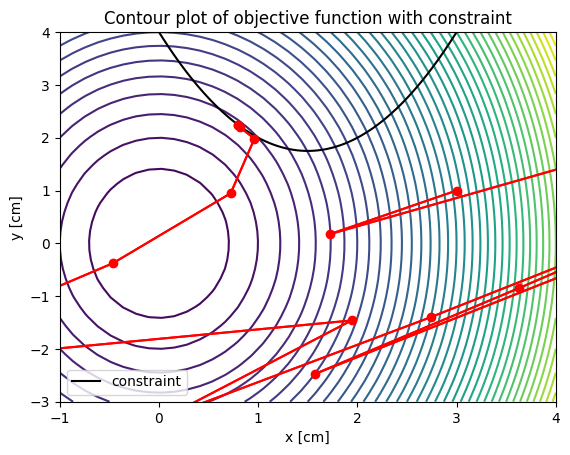

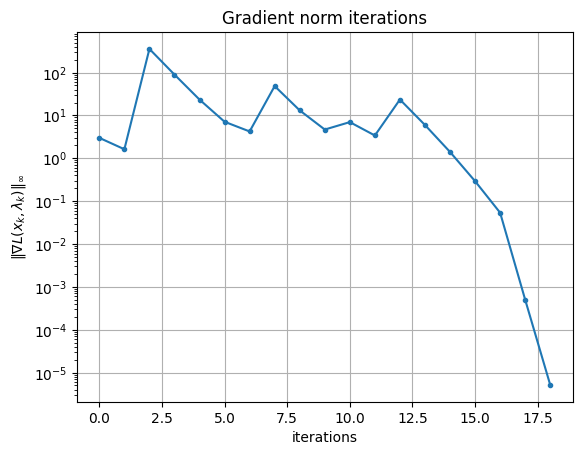

iteration: 0,   convergence_metric: 3.00e+00
iteration: 1,   convergence_metric: 1.63e+00
iteration: 2,   convergence_metric: 3.27e+00
iteration: 3,   convergence_metric: 1.43e+00
iteration: 4,   convergence_metric: 1.12e+00
iteration: 5,   convergence_metric: 8.45e-01
iteration: 6,   convergence_metric: 5.42e-01
iteration: 7,   convergence_metric: 6.46e-02
iteration: 8,   convergence_metric: 3.66e-03
iteration: 9,   convergence_metric: 4.34e-06
acceptable solution found



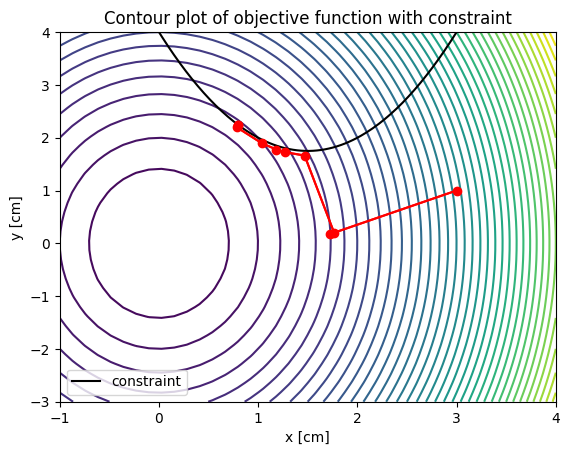

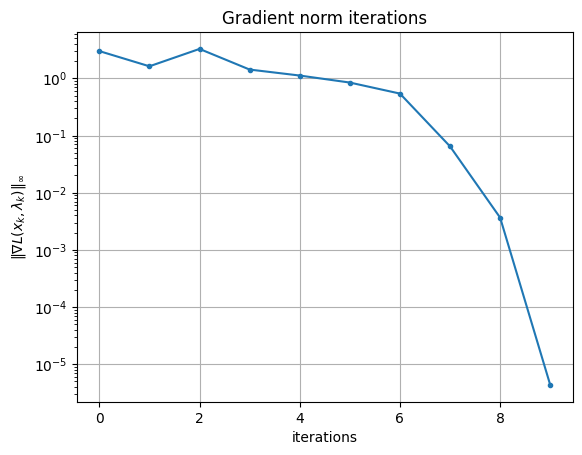

iteration: 0,   convergence_metric: 3.00e+00
iteration: 1,   convergence_metric: 1.63e+00
iteration: 2,   convergence_metric: 7.66e+01
iteration: 3,   convergence_metric: 1.93e+01
iteration: 4,   convergence_metric: 4.93e+00
iteration: 5,   convergence_metric: 1.35e+00
iteration: 6,   convergence_metric: 5.94e-01
iteration: 7,   convergence_metric: 2.94e-01
iteration: 8,   convergence_metric: 2.93e-02
iteration: 9,   convergence_metric: 2.03e-03
iteration: 10,   convergence_metric: 2.94e-06
acceptable solution found



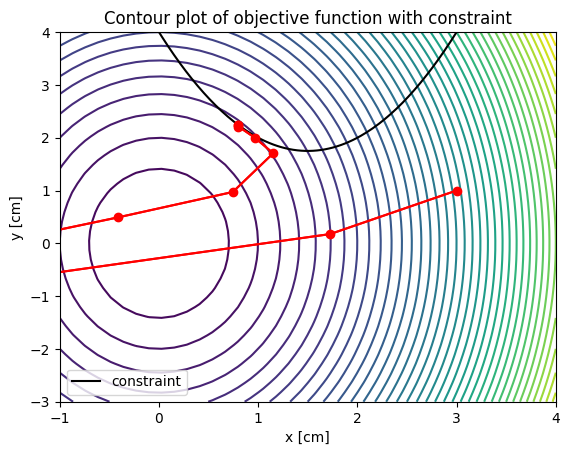

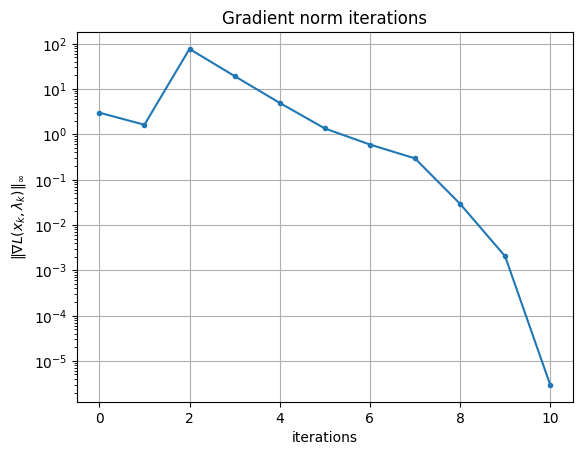

iteration: 0,   convergence_metric: 3.00e+00
iteration: 1,   convergence_metric: 1.63e+00
iteration: 2,   convergence_metric: 1.72e+00
iteration: 3,   convergence_metric: 1.13e+00
iteration: 4,   convergence_metric: 2.69e-01
iteration: 5,   convergence_metric: 4.97e-02
iteration: 6,   convergence_metric: 2.24e-03
iteration: 7,   convergence_metric: 5.39e-05
acceptable solution found



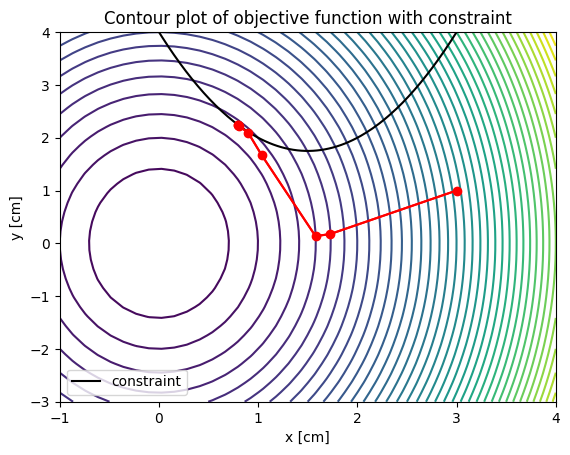

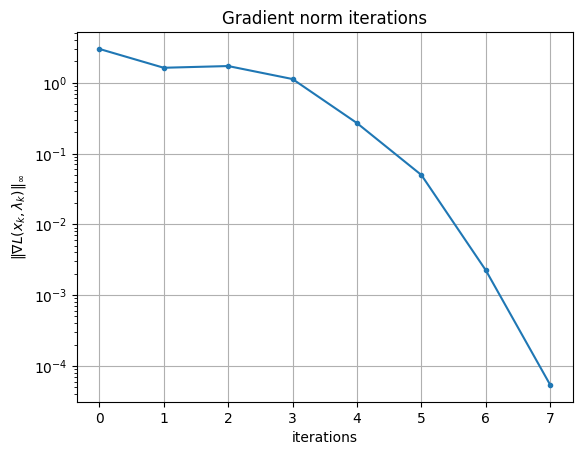

In [60]:
# No linesearch, no Powell
ex7_eq_sqp(with_line_search=False, with_powells_trick=False)

# Only linesearch
ex7_eq_sqp(with_line_search=True, with_powells_trick=False)

# Only Powell's trick
ex7_eq_sqp(with_line_search=False, with_powells_trick=True)

# Linesearch and Powell's trick
ex7_eq_sqp(with_line_search=True, with_powells_trick=True)

## Exercise 2
Consider the inequality constrained problem:
\begin{align*}
\begin{split}
\min_x & \quad f(x) \\
\text{s.t.} & \quad h(x) = 0 \\
     & \quad g(x) \leq 0
\end{split}
\end{align*}
with $f\colon\R^n\to\R$, $h\colon\R^n\to\R^m$, and $g\colon\R^n\to\R^l$.
Introduce Lagrange multipliers $\lambda\in\R^m$ and $\mu\in\R^l$ to handle the constraints:
\begin{align*}
{L}(x,\lambda,\mu) = f(x) + \lambda^T h(x) + \mu^T g(x).
\end{align*}
The optimality conditions are:
\begin{align*}
 0 &= \nabla f(x) + \nabla h(x) \lambda + \nabla g(x) \mu \\
 0 &= h(x) \\
 0 &\geq g(x) \\
 0 &\leq \mu \\
 0 &= \mu^T g(x).
\end{align*}
In the equality-constrained case we linearized and solved the optimality conditions either by solving the linear system of equations by hand, or by solving the equivalent QP with a QP solver.
It is a pain to solve something with inequalities by hand, so here we let the QP solver do the work.
The equivalent QP is:
\begin{align}
\begin{split}
\min_{\Delta x} & \ \Delta x^T\nabla f_k + \frac{1}{2}\Delta x^T \nabla_{xx}^2{L}_k\Delta x \\
\text{s.t.} & \ \nabla h_k^T \Delta x + h_k = 0 \\
              & \ \nabla g_k^T \Delta x + g_k \leq 0 \\
\end{split}
\end{align}

### Exercise 2.a
Add inequality constraints to your SQP solver by completing the code below.
You will need to get $\lambda$ and $\mu$ from the output of conic.
 Use BFGS with Powell's trick to approximate the Hessian $\nabla_{xx}^2 {L}$.
For the line search merit function, use:
\begin{align*}
\varphi_1(x) := f(x) + c \left( \|h(x)\|_1 + \|g^{+}(x)\|_1 \right)
%\label{eq:meritFunction}
\end{align*}
and
\begin{align*}
\nabla \varphi_1(x_k)^Td_k = \nabla f(x_k)^Td_k - c \left( \|h(x_k)\|_1 + \|g^{+}(x_k)\|_1 \right),
%\label{eq:meritGradient}
\end{align*}
where
\begin{align*}
g^+(x) = \max(0,g(x)) \qquad \text{ (pointwise)}.
\end{align*}

Use as stopping criterion:
\begin{align*}
\left\|
\nabla f_k + \nabla h_k \lambda_k + \nabla g_k\mu_k
\right\|_\infty
 \leq \epsilon  \\
\end{align*}
and
\begin{align*}
\left\|
\begin{pmatrix}
h_k \\
g_k^+
\end{pmatrix}
\right\|_\infty
 \leq \epsilon.
\end{align*}

In [61]:
def minimize_sqp(ffun, hfun, gfun, x0: np.array, with_line_search=True, with_powells_trick=False, callback=None):

    # convergence tolerance
    convergence_tol = 1e-4
    max_iters = 1000
    
    # make sure x0 is a column vector
    n_variables, cols = x0.shape
    if cols != 1:
        raise ValueError('x0 needs to be a column vector')
    
    # make sure ffun returns a scalar
    f0 = ffun(x0)
    if len(f0) != 1:
        raise ValueError('ffun must return a scalar')
    
    # make sure hfun returns a column vector
    h0 = hfun(x0)
    n_eq_constraints, cols = h0.shape
    if cols != 1:
        raise ValueError('hfun needs to return a column vector')
    
    # make sure gfun returns a column vector
    g0 = gfun(x0)
    n_ineq_constraints, cols = g0.shape
    if cols != 1:
        raise ValueError('gfun needs to return a column vector')
    
    n_constraints = n_eq_constraints + n_ineq_constraints
    # a log of the iterations
    x_iters = np.zeros((n_variables, max_iters))
    gradient_lagrangian_iters = np.zeros((1,max_iters))
    
    # initial variables
    x      = x0.copy()
    lambdA = np.zeros((n_eq_constraints, 1)) # lambda is a key word
    mu     = np.zeros((n_ineq_constraints, 1))
    
    # set these so the first printout doesn't fail
    dk     = np.zeros((n_variables, 1))
    alpha = 0
    qp_status = "default"
    
    # initialize B
    B = np.eye(n_variables)
    
    # evaluate the initial f and it's jacobian J
    _, J = finite_difference_jacobian(ffun, x)
    
    # evaluate the initial h and it's jacobian J_h
    h, J_h = finite_difference_jacobian(hfun, x)
    
    # evaluate the initial g and it's jacobian J_g
    g, J_g = finite_difference_jacobian(gfun, x)
    
    # Define the QP solver with Casadi
    B_placeholder = cs.DM.ones(n_variables, n_variables)
    Jh_placeholder = cs.DM.ones(n_constraints, n_variables)
    qp_struct = {   'h': B_placeholder.sparsity(),
                    'a': Jh_placeholder.sparsity()}
    

    qp_solver_opts = {}
    qp_solver_opts["print_out"] = False
    qp_solver_opts["printLevel"] = "none"

    qp_solver = cs.conic("qpsol", "qpoases", qp_struct, qp_solver_opts)

    # Main optimization loop
    for k in range(max_iters):
        
        # check for divergence
        x_norm_inf = np.linalg.norm(x, np.inf)
        if x_norm_inf > 1e6:
            raise ValueError('minimize_sqp has diverged, ||x||_\{inf\}: %.3g',x_norm_inf)
        
        # check for bad BFGS update
        if np.any(np.any(np.isnan(B))):
            raise ValueError('BFGS has NaNs in it, step size is probably very small')
        
        # store x in the iteration log
        gradient_lagrangian = J.T + J_h.T  @ lambdA + J_g.T @ mu
        norm_gradient_lagrangian = np.linalg.norm(gradient_lagrangian, np.inf)
        norm_infeasbility = np.linalg.norm( np.vstack((h, np.fmax(g,0))), np.inf)
    
        norm_convergence = np.fmax(norm_gradient_lagrangian, norm_infeasbility)

        x_iters[:,[k]] = x.copy()
        gradient_lagrangian_iters[0, k] = norm_convergence
        
        # Iteration output
        if k % 10 == 0:
            print('{0: >8}{1: >20}{2: >20}{3: >30}{4: >15}{5: >7}'.format("iter", "qpstatus", "||grad_L||", "||infeasibility_measure||", "||step||", "t"))
        print('{0: >8d}{1: >20}{2: >20.4e}{3: >30.4e}{4: >15.4e}{5: >7.4f}'.format(k, qp_status, norm_gradient_lagrangian, norm_infeasbility, np.linalg.norm(dk,np.inf), alpha))
        
        if callback is not None:
            callback(x)

        # check for convergence
        if norm_convergence < convergence_tol:
            x_iters = x_iters[:,:k+1]
            gradient_lagrangian_iters = gradient_lagrangian_iters[:,:k+1]
            print('acceptable solution found\n')
            return x, x_iters, gradient_lagrangian_iters
        
        x_old = x.copy()
        
        # find the search direction and lambda
        #raise NotImplementedError("TODO: Implement the QP solver")
        lba = cs.vertcat(-h, -cs.inf*cs.DM.ones(n_ineq_constraints))
        uba = cs.vertcat(-h, -g)

        result = qp_solver(h=B,
                           a=cs.vertcat(J_h, J_g),
                           g=J,
                           lba=lba,
                           uba=uba)
        
        dk = np.array(result['x'])
        lambdA = np.array(result['lam_a'])[:n_eq_constraints]
        mu = np.array(result['lam_a'])[n_eq_constraints:]
        qp_status = qp_solver.stats()['return_status']
        
    
        ### END OF DIFFERENT APPROACHES ---------------------------------------
        # take the line search
        if with_line_search:
            sigma = 0.01
            beta  = 0.6
            c     = 100

            #raise NotImplementedError("TODO: Implement the directional derivative")
            directional_derivative = J @ dk - c*np.linalg.norm(h,1) - c*np.linalg.norm(np.fmax(g,0),1)
            merit_fun = lambda y : merit_function_inequality_constrained_sqp(ffun, hfun, gfun, c, y)
            x, alpha = line_search(merit_fun, x, directional_derivative, dk, sigma, beta)
        else:
            x += dk

        # update BFGS hessian approximation
        J_old   = J.copy()
        J_h_old = J_h.copy()
        J_g_old = J_g.copy()
        
        # evaluate F and it's jacobian J
        _, J = finite_difference_jacobian(ffun, x)
    
        # evaluate h and it's jacobian J_h
        h, J_h = finite_difference_jacobian(hfun, x)
        
        # evaluate g and it's jacobian J_g
        g, J_g = finite_difference_jacobian(gfun, x)
        
        #raise NotImplementedError("TODO: Implement the Lagrangian gradients!")
        Lx_old = J_old.T + J_h_old.T @ lambdA + J_g_old.T @ mu
        Lx     = J.T + J_h.T @ lambdA + J_g.T @ mu
        
        s = x - x_old
        y = Lx - Lx_old

        # Powell's trick
        if with_powells_trick:
            if y.T @ s >= 0.2 * s.T @ B @ s:
                theta = 1
            else:
                theta = (0.8 * s.T @ B @ s)/(s.T @ B @ s -s.T @ y)

            y = theta*y + (1-theta) * B @ s
        else:
            y = y
        
        B = B - B@(s@s.T)@B/(s.T @B@s) + y@y.T/(s.T@y)
        B = (B + B.T) / 2 # Symmetrize Hessian, only needed due to numerical inaccuracy, so that quadprog doesn't complain
        ###############################################################
    
    raise RuntimeError('minimize_sqp: max iterations exceeded')


### Exercise 2.b
Verify your modification by solving
\begin{align*}
\begin{split}
\min_{x,y} & \ \frac{1}{2}\left( x^2 + \left(\frac{y}{2}\right)^2 \right) \\
\text{s.t.} & \ y = (x-1)^2 - x + 3 \\
              & \ 0 \leq 2x - 0.4x^2 - y
\end{split}
\end{align*}

To do this, we define the inequality constraint function below:

In [62]:
# Inequality constraint function
def gfun(xy):
    # such that g(x) <= 0
    x = xy[0]
    y = xy[1]
    
    g = -2.0*x + 0.4*x**2 + y
    return np.array([g])


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          3.0000e+00                    3.0000e+00     0.0000e+00 0.0000
       1  Successful return.          1.4662e+00                    1.6256e+00     1.2750e+00 1.0000
       2  Successful return.          2.2622e+01                    1.6148e+00     2.7008e+00 0.2160
       3  Successful return.          1.9776e+00                    4.1723e-03     1.5685e+00 1.0000
       4  Succe

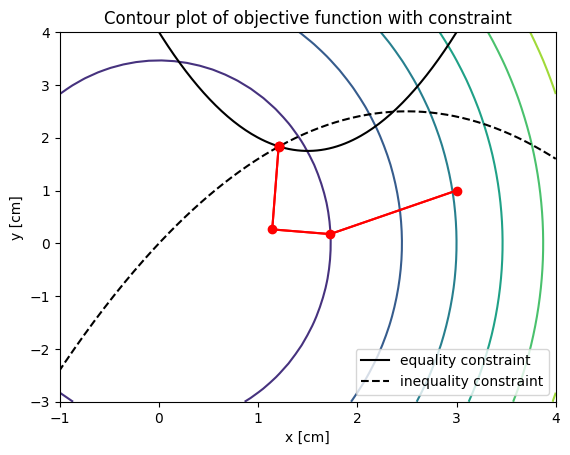

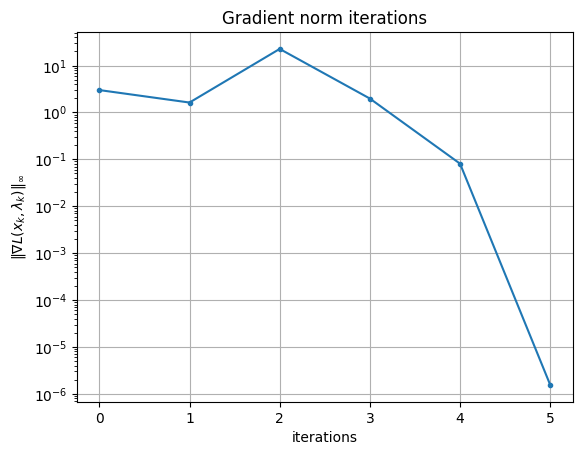

In [63]:
def ex7_sqp(with_line_search=True, with_powells_trick=False, plot_function=False):

    # ------ First let's plot the function ------
    # Define the the meshgrids for the 2D function
    xlist = np.linspace(-1, 4, 40)
    ylist = np.linspace(-3, 4, 40)
    [X,Y] = np.meshgrid(xlist, ylist)
    obj = np.vectorize(lambda x, y: ffun([x, y]), signature="(),()->()")(X, Y)

    if plot_function:
        # Plot contour lines
        fig =plt.figure()
        c = plt.contour(X, Y, obj, 40)
        
        t = np.linspace(-4,4,400)
        plt.plot(t, 3 + (t-1)**2 - t, color='black', label='equality constraint')
        plt.plot(t, 2*t - 0.4*t**2,color='black', label='inequality constraint', linestyle="dashed")
    
        plt.title('Contour plot of objective function with constraint')
        plt.xlabel('x [cm]')
        plt.ylabel('y [cm]')
        plt.xlim((-1, 4))
        plt.ylim((-3, 4))
        plt.legend()
        plt.show()

    # ------ Solve the problem ------
    x0 = np.array([[3.0],[1.0]])

    _, x, gradients_lagrangian = minimize_sqp(ffun, hfun, gfun, x0, with_line_search=with_line_search, with_powells_trick=with_powells_trick)

    n_iter = gradients_lagrangian.shape[1]

    # # ------ Plot the solution ------
    # Plot iterates x
    # Plot contour lines
    fig = plt.figure()
    c = plt.contour(X, Y, obj)
    t = np.linspace(-4,4,400)
    plt.plot(t, 3 + (t-1)**2 - t, color='black', label='equality constraint')
    plt.plot(t, 2*t - 0.4*t**2,color='black', label='inequality constraint', linestyle="dashed")

    plt.plot(x[0,:], x[1,:],color='r')
    plt.plot(x[0,:], x[1,:],color='r', marker="o")
    plt.title('Contour plot of objective function with constraint')
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')
    plt.xlim((-1, 4))
    plt.ylim((-3, 4))
    plt.legend()
    plt.show()

    # Plot convergence
    plot_convergence(n_iter, gradients_lagrangian)

ex7_sqp()

### Exercise 2.c
Try solving the problem with both line search and full step. What is the
difference?


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          3.0000e+00                    3.0000e+00     0.0000e+00 0.0000
       1  Successful return.          1.4662e+00                    1.6256e+00     1.2750e+00 0.0000
       2  Successful return.          1.0264e+02                    7.2942e+00     2.7008e+00 0.0000
       3  Successful return.          2.5115e+01                    1.7442e+00     1.3207e+00 0.0000
       4  Succe

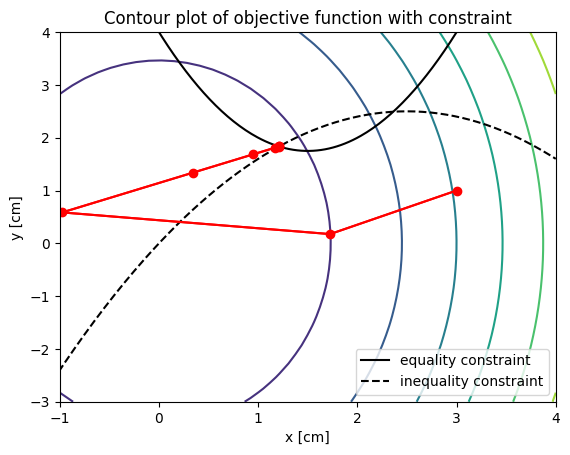

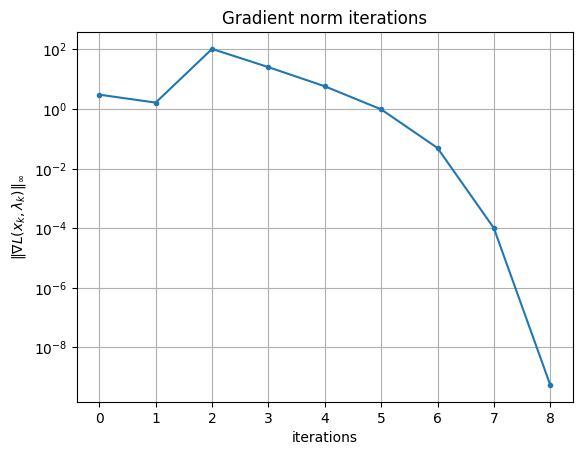


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          3.0000e+00                    3.0000e+00     0.0000e+00 0.0000
       1  Successful return.          1.4662e+00                    1.6256e+00     1.2750e+00 1.0000
       2  Successful return.          2.2622e+01                    1.6148e+00     2.7008e+00 0.2160
       3  Successful return.          1.9776e+00                    4.1723e-03     1.5685e+00 1.0000
       4  Succe

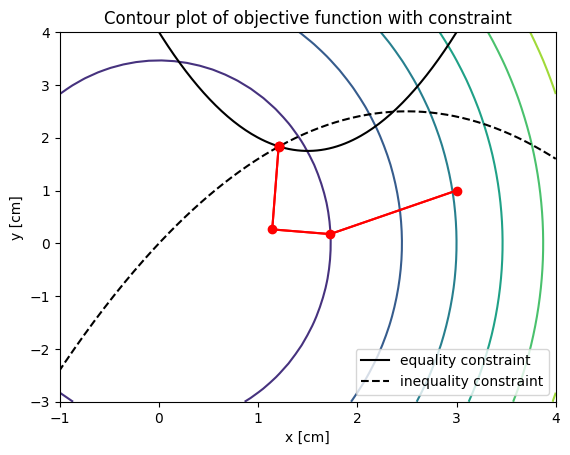

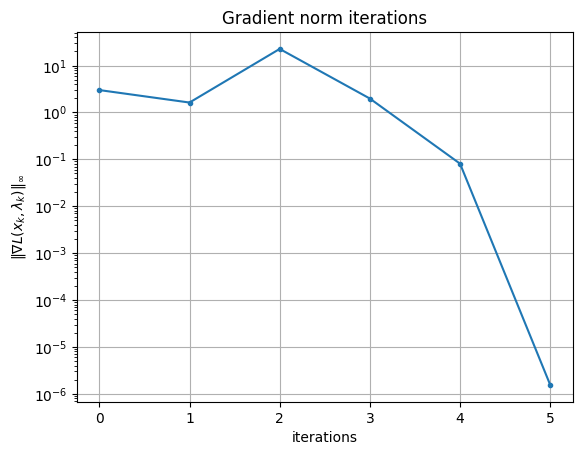


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          3.0000e+00                    3.0000e+00     0.0000e+00 0.0000
       1  Successful return.          1.4662e+00                    1.6256e+00     1.2750e+00 0.0000
       2  Successful return.          6.6870e+01                    7.2942e+00     2.7008e+00 0.0000
       3  Successful return.          1.6351e+01                    1.7442e+00     1.3207e+00 0.0000
       4  Succe

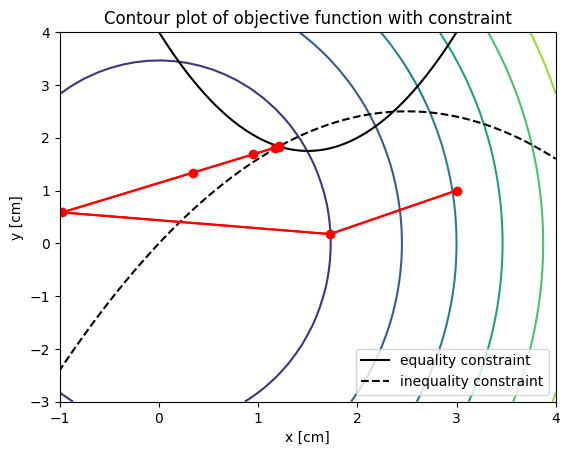

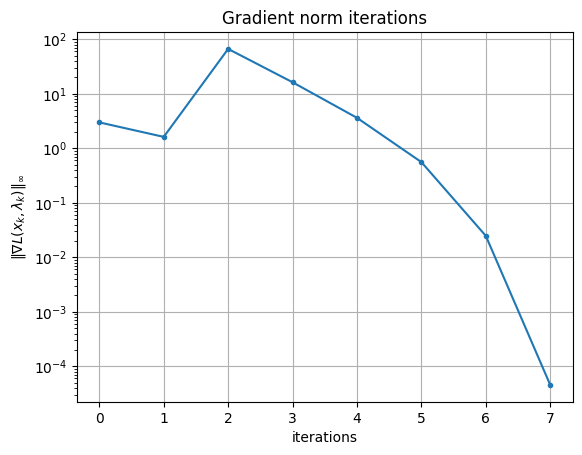


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          3.0000e+00                    3.0000e+00     0.0000e+00 0.0000
       1  Successful return.          1.4662e+00                    1.6256e+00     1.2750e+00 1.0000
       2  Successful return.          1.3618e+01                    1.6148e+00     2.7008e+00 0.2160
       3  Successful return.          1.2787e+00                    4.1723e-03     1.5685e+00 1.0000
       4  Succe

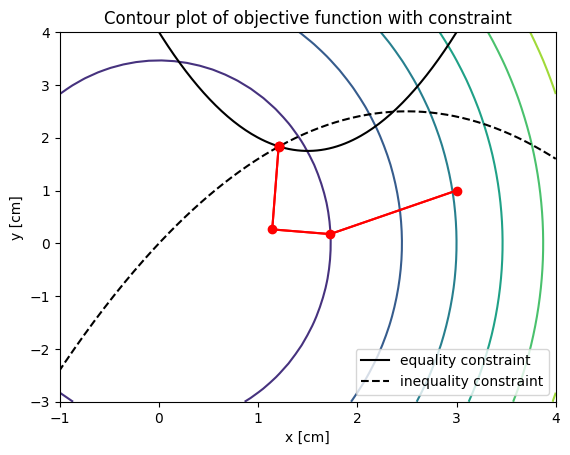

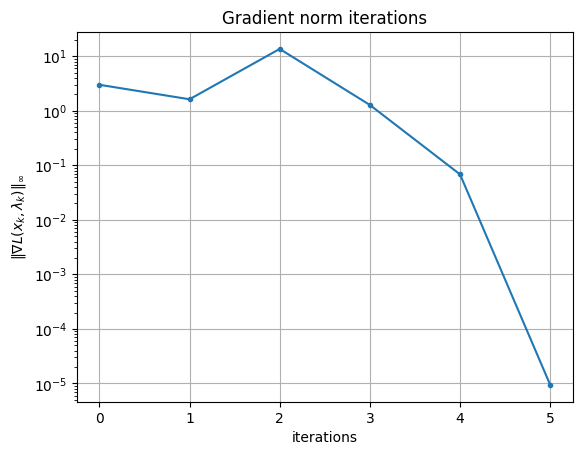

In [64]:
# No linesearch, no Powell
ex7_sqp(with_line_search=False, with_powells_trick=False)

# Only linesearch
ex7_sqp(with_line_search=True, with_powells_trick=False)

# Only Powell's trick
ex7_sqp(with_line_search=False, with_powells_trick=True)

# Linesearch and Powell's trick
ex7_sqp(with_line_search=True, with_powells_trick=True)

## Exercise 3
We will solve the hanging chain problem. In this case we will consider a completely inelastic chain where the distance between links is fixed, and the chain is partially resting on an inclined table with slope $0.15$:
\begin{align*}
\begin{split}
\min_{x_1..x_N,y_1..y_N} & \ \sum_{k=1}^N y_k  \\
\text{s.t.} & \ x_1 = -1  \\
              & \ x_N = 1  \\
              & \ y_1 = 1  \\
              & \ y_N = 1  \\
              & \ (x_{k+1} - x_k)^2 + (y_{k+1} - y_k)^2 = r^2, \,\,\,\,\, k=1 \dots N-1 \\
              & \ y_k \geq 0.15 x_k + 0.3, \,\,\,\,\, k=1 \dots N
\end{split}
\end{align*}
with $r=1.4 \cdot 2/N$.

### Exercise 3.a
Complete the code below to solve this problem.
Start by trying to solve this for small $N$, and see how large you can make $N$.
Be extremely careful about the initial guess. You can use as initial guess 
x0=np.linspace(-1,1,N), y0=np.ones(1,N).

In [74]:
def ffun(xy: np.array):
    N = round(xy.shape[0]/2)
    x = xy[:N]
    y = xy[N:]
    f = np.sum(y)
    return np.array([[f]])

def hfun(xy):
    N = round(xy.shape[0]/2)
    r = 1.4*2/N
    x = xy[:N]
    y = xy[N:]
    
    h = (x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 - r**2
    h = np.vstack((h, 
                   x[0] + 1,
                   x[-1] - 1,
                   y[0] - 1,
                   y[-1] - 1))
    return h

def gfun_linear(xy):
    N = round(xy.shape[0]/2)
    x = xy[:N]
    y = xy[N:]

    g = 0.15*x + 0.3 - y
    return g


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          1.0000e+00                    8.5197e-03     0.0000e+00 0.0000
       1  Successful return.          9.7800e+01                    7.0864e-03     1.7328e+00 0.2160
       2  Successful return.          5.7570e+00                    6.9541e-03     6.2351e-01 0.0778
       3  Successful return.          4.4349e+00                    9.3555e-03     7.7409e-01 0.0778
       4  Succe

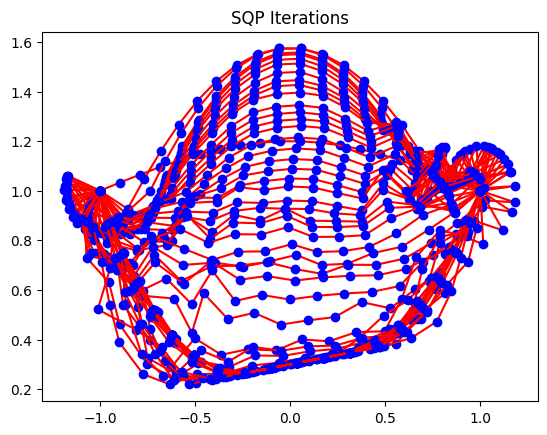

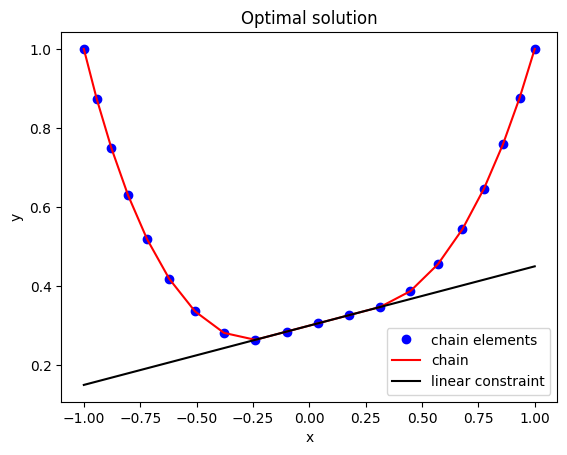

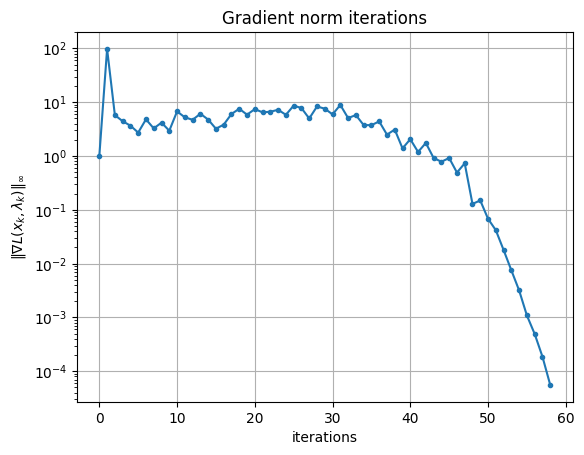

In [76]:
def ex7_sqp_chain(use_linear_constraints=True):
    N = 20

    x0 = np.linspace(-1,1,N)

    # Different initial guesses for y
    # y0 = np.ones(N)
    y0 = 1+0.2*np.cos(x0*np.pi/2)

    if use_linear_constraints:
        gfun = gfun_linear
    else:
        gfun = gfun_quadratic

    xy0 = np.vstack((x0.reshape((N,1)), y0.reshape((N,1))))

    [xy ,_, gradients_lagrangian] = minimize_sqp(ffun, hfun, gfun, xy0, with_line_search=True, with_powells_trick=True, callback=callback)
    x = xy[:N]
    y = xy[N:]
    n_iter = gradients_lagrangian.shape[1]

    # # ------ Plot the solution ------
    # plot solution
    fig1 = plt.figure()
    plt.plot(x, y, 'bo', label='chain elements')
    plt.plot(x, y, 'r', label='chain')

    if use_linear_constraints:
        plt.plot(x, 0.15*x+0.3, color='k', label="linear constraint")
    else:
        plt.plot(x, -0.6*x**2 +0.15*x +0.5, color='k', label='quadratic constraint')

    title_str = "Optimal solution"
    plt.title(title_str)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    # Plot convergence
    plot_convergence(n_iter, gradients_lagrangian)

def callback(x):
    N = round(x.shape[0]/2)
    plt.plot(x[0:N], x[N:],'r')
    plt.plot(x[0:N], x[N:],'bo')
    plt.title("SQP Iterations")

ex7_sqp_chain(use_linear_constraints=True)

### Exercise 3.b
In the code above, try different initial guesses like y0=1+0.2*np.cos(x0*pi/2). Can you explain
this behavior?

### Exercise 3.a
Remove the convex constraint
\begin{align*}
y_k \geq 0.15x_k + 0.3, \,\,\,\,\, k=1 \dots N
\end{align*}

and add the non-convex constraint

\begin{align*}
y_k \geq -0.6x_k^2 + 0.15x_k + 0.5, \,\,\,\,\, k=1 \dots N
\end{align*}

and soblem again.ve the pro Comment on t.lem again.


In [77]:
def gfun_quadratic(xy):
    N = round(xy.shape[0]/2)
    x = xy[:N]
    y = xy[N:]

    g = -0.6*(x**2) + 0.15*x + 0.5 - y # non convex
    return g


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter            qpstatus          ||grad_L||     ||infeasibility_measure||       ||step||      t
       0             default          1.0000e+00                    8.5197e-03     0.0000e+00 0.0000
       1  Successful return.          9.7800e+01                    7.0864e-03     1.7328e+00 0.2160
       2  Successful return.          5.7401e+00                    8.9007e-03     6.0646e-01 0.1296
       3  Successful return.          6.2039e+00                    1.5834e-02     6.6512e-01 0.1296
       4  Succe

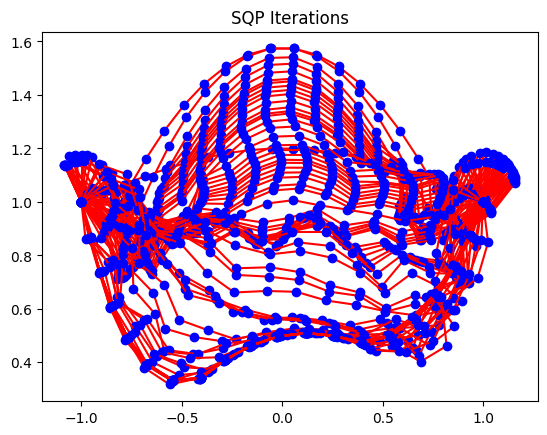

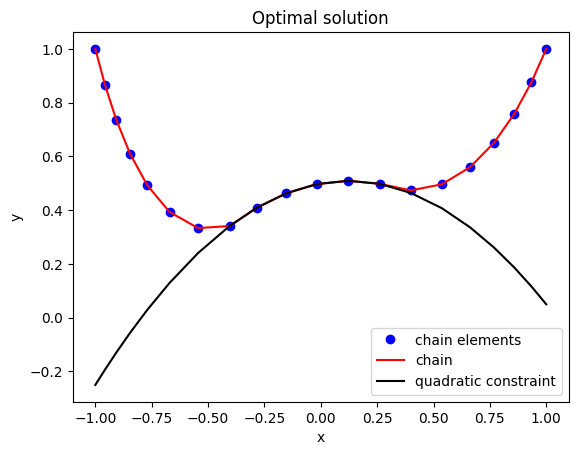

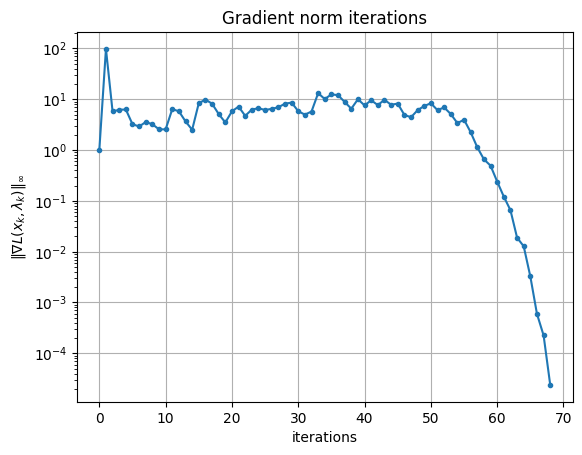

In [78]:
ex7_sqp_chain(use_linear_constraints=False)